### 0. Imports et al.

Thanks to Paul for the following functions!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import time
import pandas as pd

import os
while not os.path.exists('files'):
    os.chdir('..')
print("Current directory:", os.getcwd())

Current directory: /home/kiwi/documents/zurich/compastro


In [2]:
#------------------------------#
#--------- PARAMETERS ---------#
#------------------------------#

G = 1 # gravitational constant
M = 1 # attracting mass in (0,0)
dt= 1e-3 # time step
x_0, y_0 = (1,0) #initial position of the particle (pericenter of the ellipse)
e = 0.5 #eccentricity of the ellipse to obtain from the integration
vx_0, vy_0 = (0, np.sqrt(1+e)) #initial speed of the particle

#------------------------------#
#------ EXPECTED RESULTS ------#
#------------------------------#

a = 1/(1-e) # semi-major axis
b = np.sqrt((1+e)/(1-e))
E = -(1-e)/2 # energy of the orbit
L = np.sqrt(1+e) # angular momentum
apo = -(1+e)/(1-e) # apocenter = -b^2/a
x_c, y_c = (-e/(1-e), 0) # center of the ellipse
T = 2*np.pi/(1-e)**(3/2) # period

# Number of time steps
k = 3 # number of periods to simulate
N = int(np.ceil(k * T/dt)) # for k periods
t_ref = [i*dt for i in range(N)] #time array

print(N)

# Expected ellipse
x_ref = [x_c + a*np.cos(t/T*2*np.pi) for t in t_ref]
y_ref = [y_c + b*np.sin(t/T*2*np.pi) for t in t_ref]

# Polar coordinates
theta_ref = np.linspace(-np.pi, np.pi, 1000)
r_ref = (1+e)/(1+e*np.cos(theta_ref))

#------------------------------#
#------ GENERAL FUNCTIONS -----#
#------------------------------#

def r(x,y):
    return np.sqrt(x**2 + y**2)

def v(vx, vy):
    return np.sqrt(vx**2 + vy**2)

def f(Y,t):
    x, y, v_x, v_y = Y
    r_ = r(x,y)
    v_ = v(v_x, v_y)
    dv_x = -G*M*x/(r_**3)
    dv_y = -G*M*y/(r_**3)
    return [v_x, v_y, dv_x, dv_y]

def plot_checks(Y_solver, solver_name, solver_time):
    fig = plt.figure(figsize = (20,16))
    # 1st subplot
    ax1 = fig.add_subplot(221)
    ax1.plot(x_ref, y_ref, color = 'g', label = 'Theory')
    ax1.plot(Y_solver[:,0], Y_solver[:,1], color='r', label=solver_name)
    ax1.scatter(x_c, y_c, color='k', label = 'Center')
    ax1.scatter(apo,0, label='Apocenter', color='k', marker='x')
    ax1.scatter(x_0, y_0, label='Pericenter', color='k', marker='+')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.tick_params(axis='x',labelsize=14)
    ax1.tick_params(axis='y',labelsize=14)
    ax1.set_title('Trajectory in x-y plane', fontsize = 16)
    ax1.legend(loc='upper right')

    # 2nd subplot
    ax2 = fig.add_subplot(222)
    theta = [math.atan2(Y_solver[i,1],Y_solver[i,0]) for i in range(N)]
    r_sim = [r(Y_solver[i,0], Y_solver[i,1]) for i in range(N)]
    ax2.plot(theta_ref, r_ref, color = 'g', label = 'Theory')
    ax2.scatter(theta, r_sim, color='r', s=1, marker ='x', label=solver_name)
    ax2.hlines([abs(apo)], xmin=theta_ref[0], xmax=theta_ref[-1], linestyle='dashed', label='Apogee')
    ax2.hlines([1], xmin=theta_ref[0], xmax=theta_ref[-1], linestyle='dashed', color= 'orange', label='Perigee')
    ax2.set_xlabel(r'$\theta$ [rad]', fontsize=16)
    ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_xticklabels([r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax2.set_ylabel('r', fontsize=16)
    ax2.tick_params(axis='x',labelsize=14)
    ax2.tick_params(axis='y',labelsize=14)
    ax2.set_title(r'Trajectory in $\theta$-r plane', fontsize = 16)
    ax2.legend()

    # 3rd subplot
    ax3 = fig.add_subplot(223)
    E_kin = np.array([1/2*v(Y_solver[i,2], Y_solver[i,3])**2 for i in range(N)])
    E_pot = np.array([-1/r(Y_solver[i,0], Y_solver[i,1]) for i in range(N)])
    E_tot = np.array([E_kin[i]+E_pot[i] for i in range(N)])
    ax3.plot(t_ref, E_kin, label = 'Kinetic energy: ' + solver_name)
    ax3.plot(t_ref, E_pot, label = 'Potential energy: ' + solver_name)
    ax3.plot(t_ref, E_tot, color='r', label='Total energy: ' + solver_name)
    ax3.hlines(E, xmin=t_ref[0], xmax=t_ref[-1], color='k', linestyle='dashed', label='Theory')
    ax3.set_xlabel('t', fontsize=16)
    ax3.set_ylabel('E', fontsize=16)
    ax3.tick_params(axis='x',labelsize=14)
    ax3.tick_params(axis='y',labelsize=14)
    ax3.set_title('Conservation of energy', fontsize = 16)
    ax3.legend()

    # 4th subplot
    ax4 = fig.add_subplot(224)
    L_z = np.array([Y_solver[i,0]*Y_solver[i,3] - Y_solver[i,1]*Y_solver[i,2] for i in range(N)])
    ax4.plot(t_ref, abs(L_z-L)/L, label = 'Rel. error Angular momentum:' + solver_name)
    ax4.plot(t_ref, abs(E_tot-E)/abs(E), color='r', label='Rel. error energy: ' + solver_name)
    ax4.set_xlabel('t', fontsize=16)
    ax4.set_yscale('log')
    ax4.set_ylabel('relative error', fontsize=16)
    ax4.tick_params(axis='x',labelsize=14)
    ax4.tick_params(axis='y',labelsize=14)
    ax4.set_title('Relative errors', fontsize = 16)
    ax4.legend()

    # General 
    plt.suptitle(f'Time integration results for {solver_name} method, computation time {solver_time:.3f}s', fontsize = 16)
    plt.legend()
    plt.show()

53315


In [3]:
def getSimulation(solver_name):
    euler = pd.read_csv(f"files/tests/integration_methods_notebook/{solver_name}.csv")
    euler = euler[::2]
    Y_euler = np.array(euler[['x', 'y', 'vx', 'vy']])
    return Y_euler

### 1. Explicit Euler

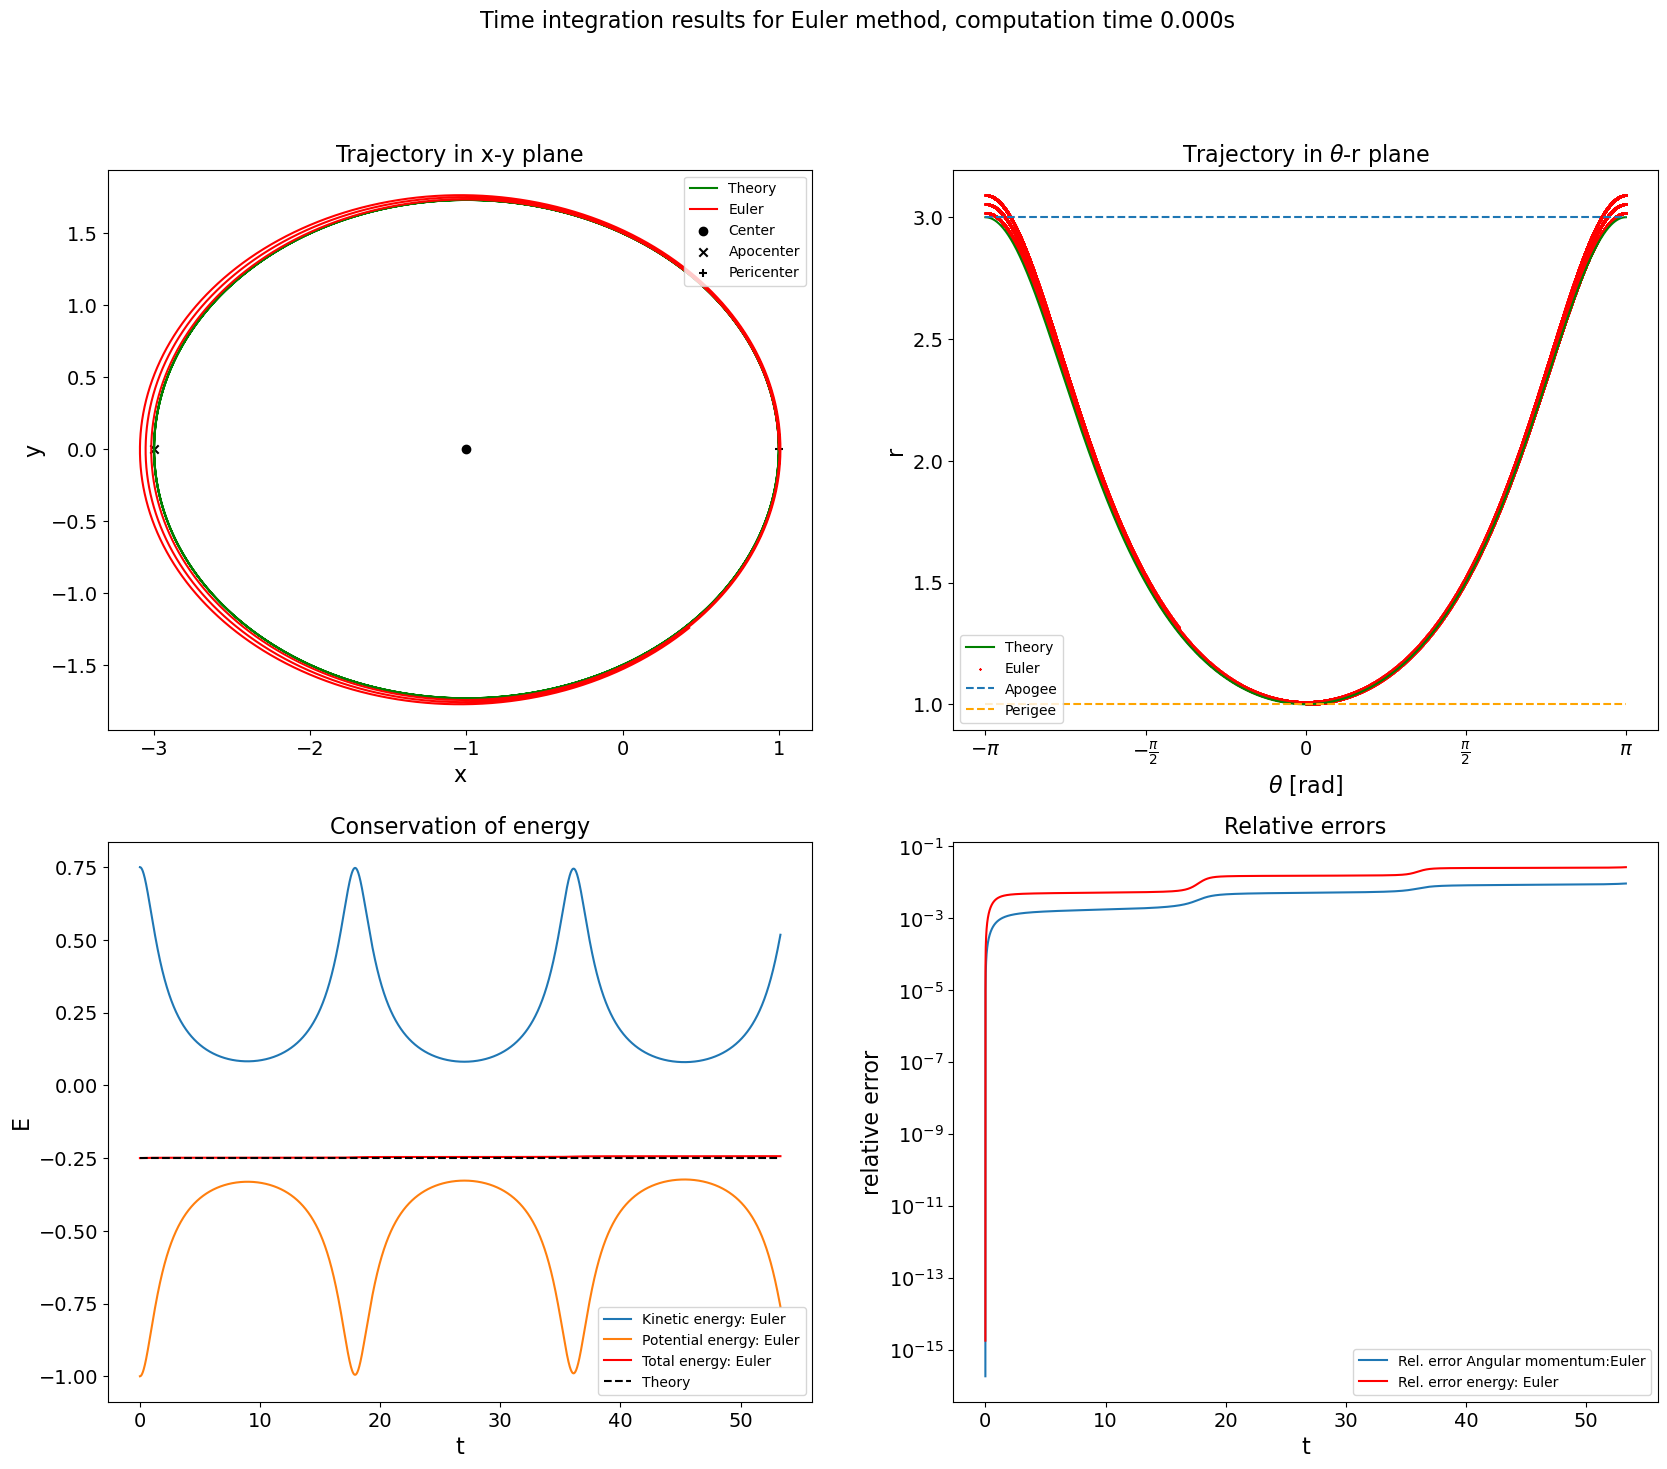

In [4]:
Y_euler = getSimulation('euler')
Euler_time = 0

plot_checks(Y_euler, solver_name = 'Euler', solver_time=Euler_time)

### 2. RK2

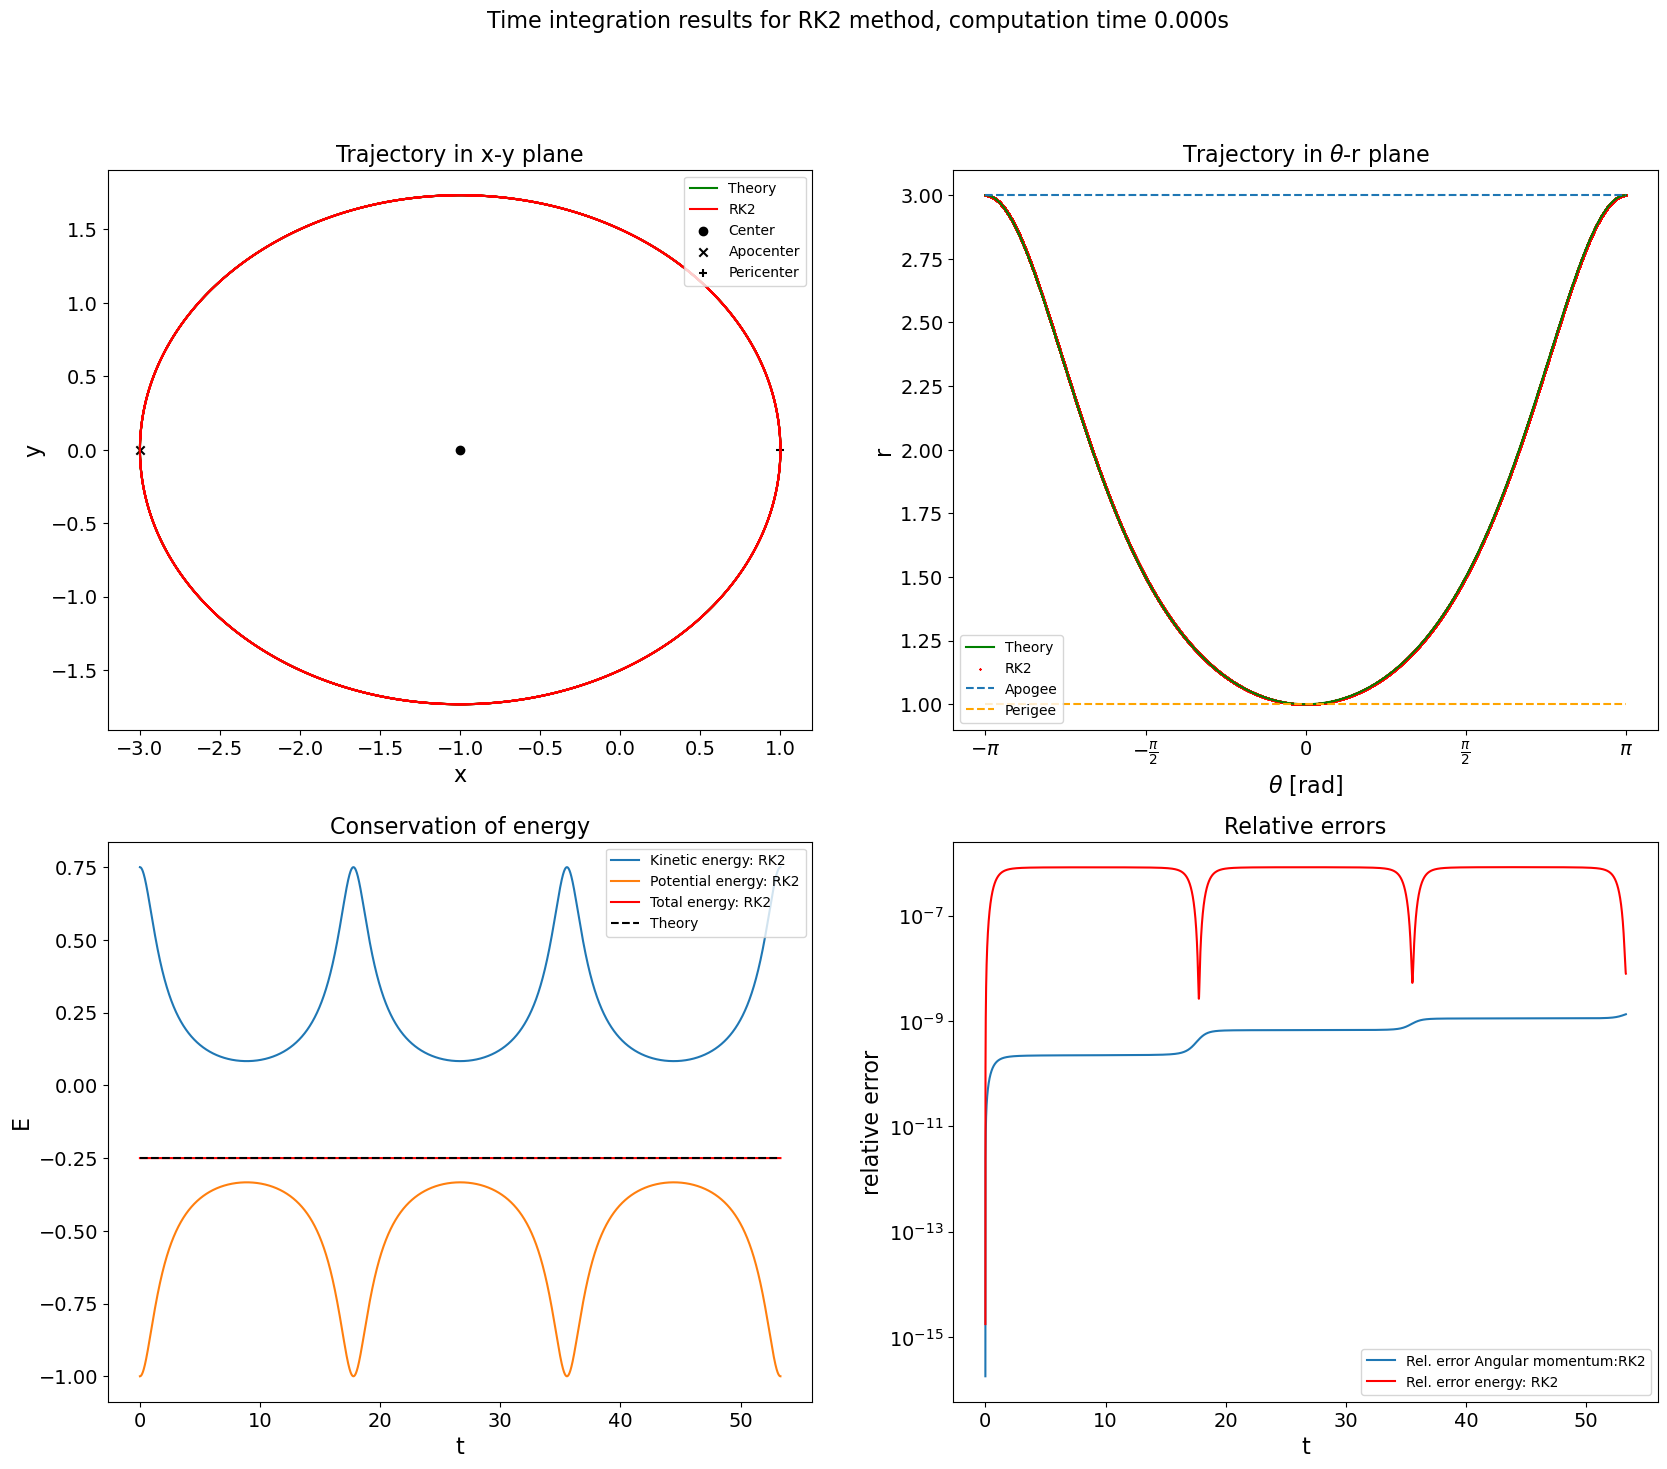

In [5]:
Y_rk2 = getSimulation('rk2')
RK2_time = 0

plot_checks(Y_rk2, solver_name='RK2', solver_time=RK2_time)

### 3. RK4

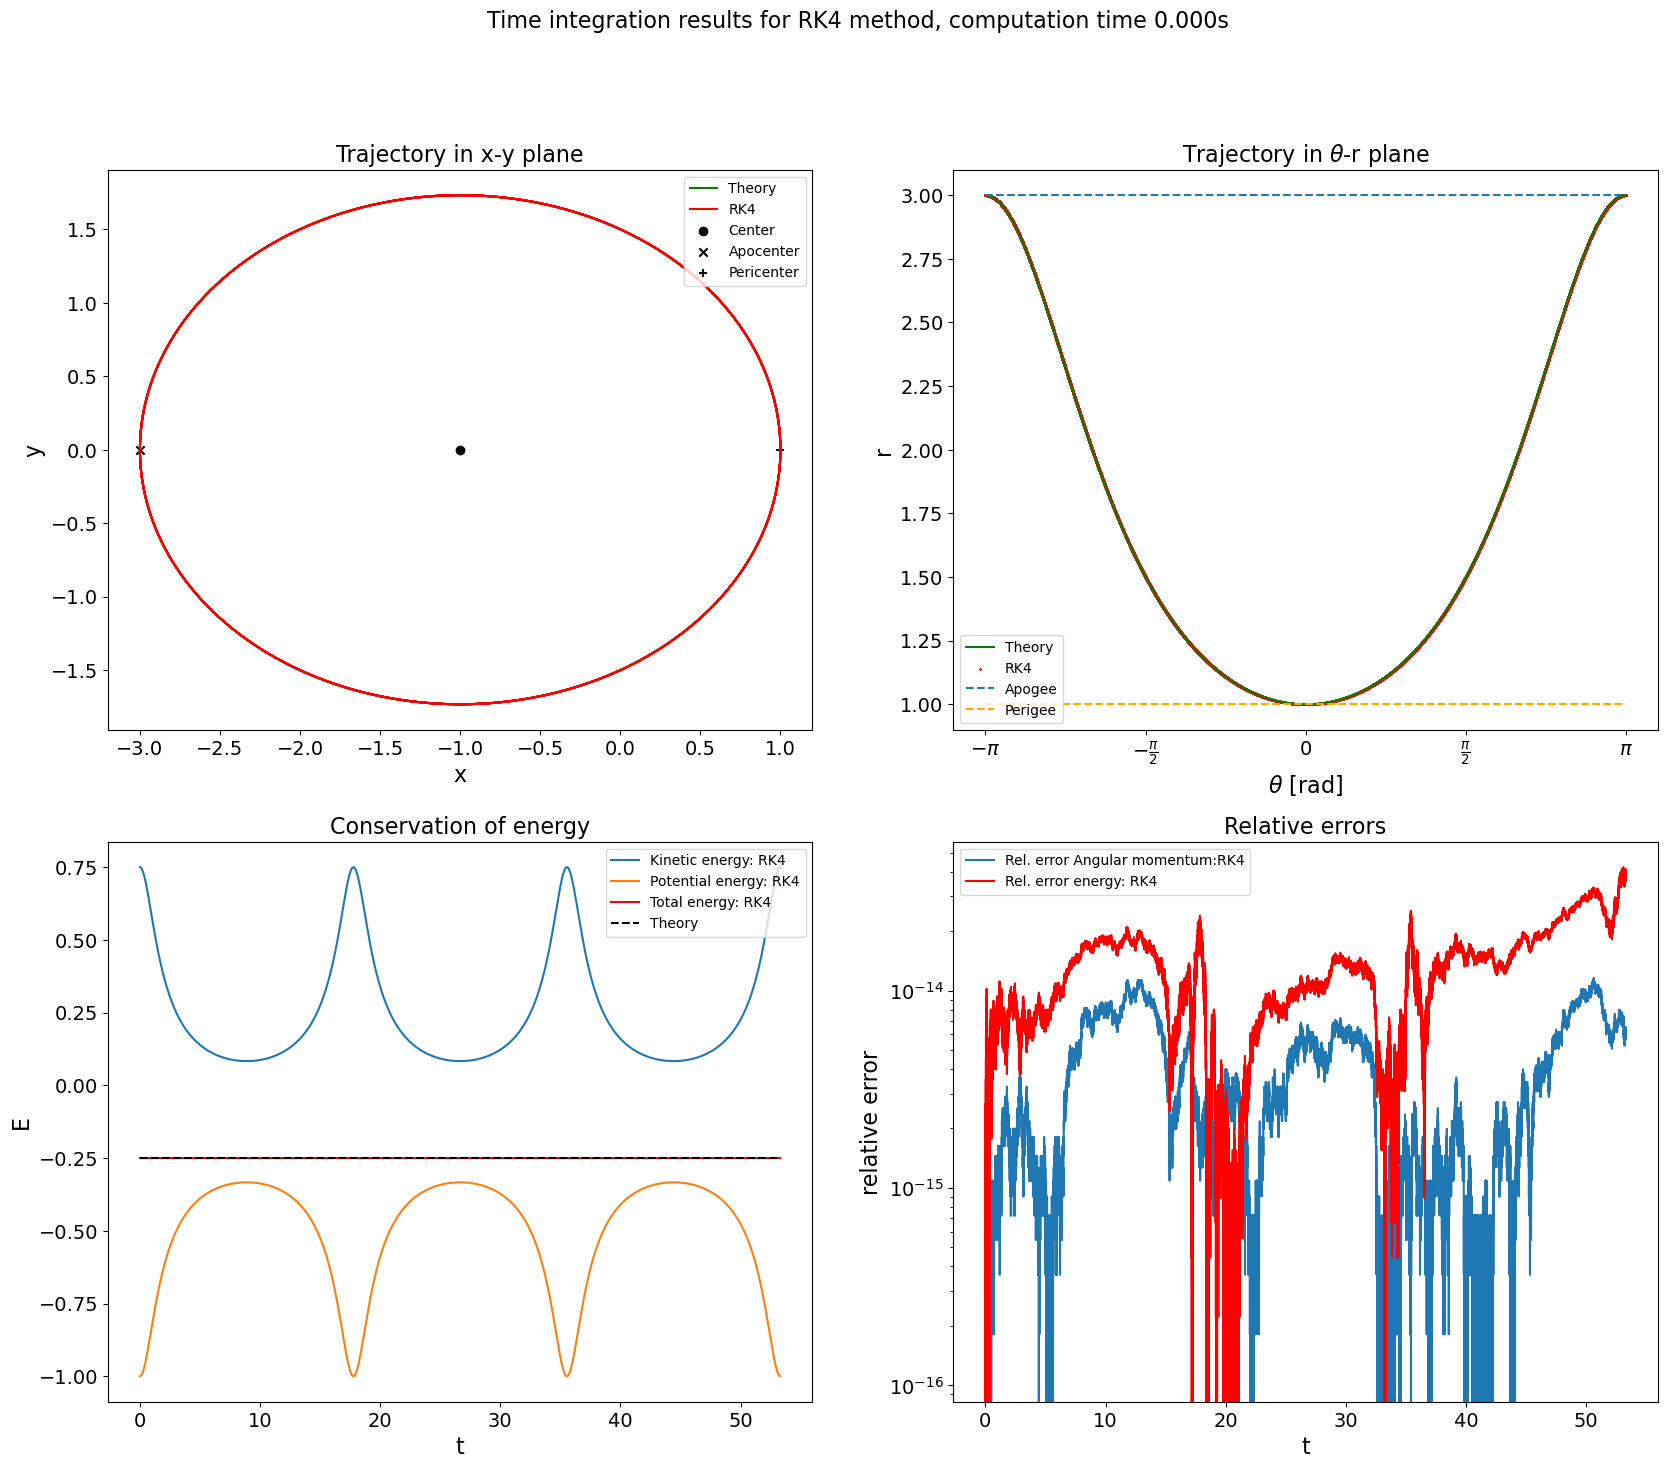

In [6]:
Y_rk4 = getSimulation('rk4')
RK4_time = 0

plot_checks(Y_rk4, solver_name='RK4', solver_time = RK4_time)

### 4. Leapfrog

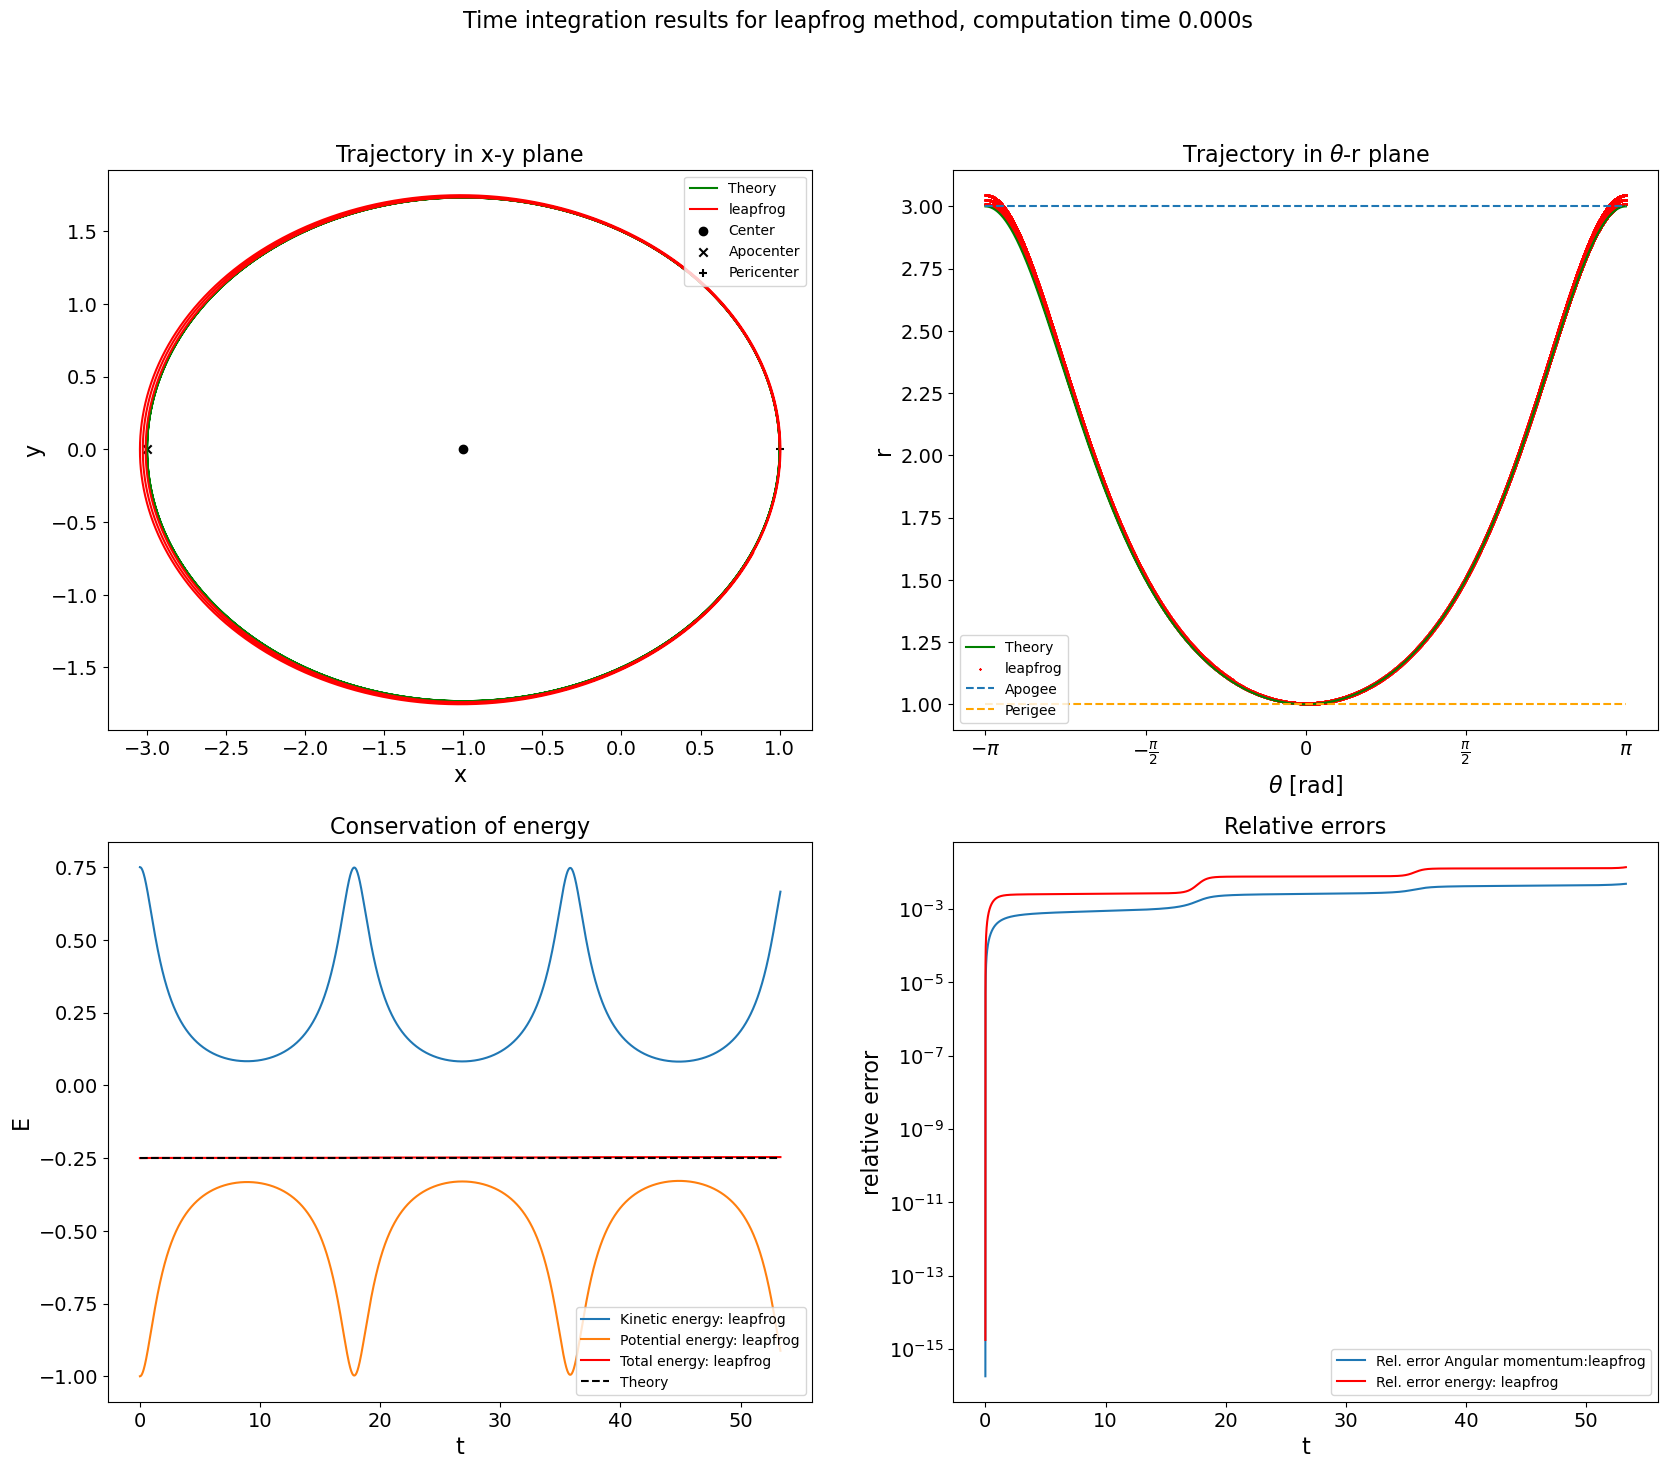

In [7]:
Y_leapfrog = getSimulation('leapfrog')
leapfrog_time = 0

plot_checks(Y_leapfrog, solver_name='leapfrog', solver_time = leapfrog_time)

### 5. Semi-implicit Euler

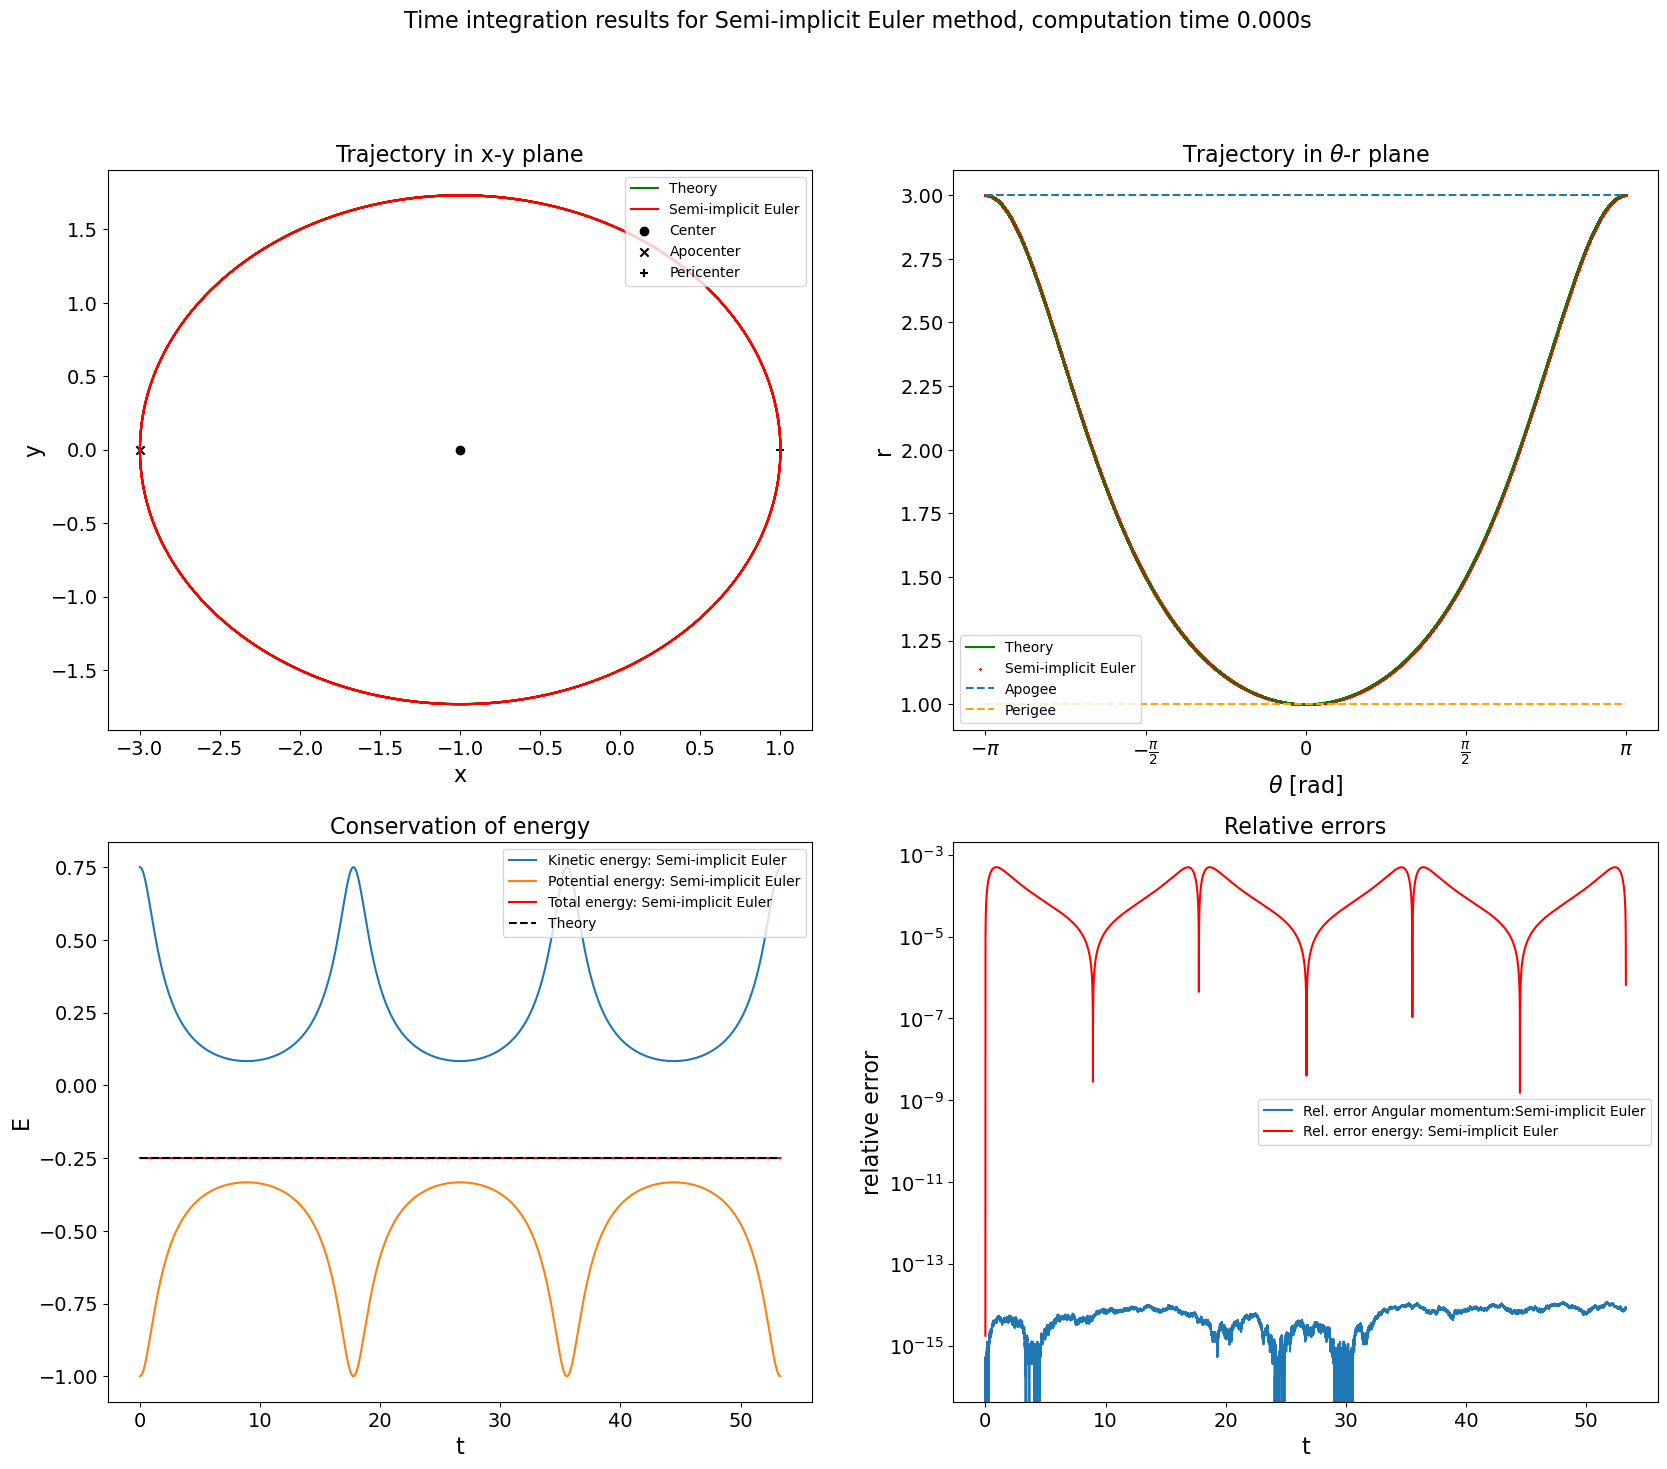

In [8]:
Y_semi = getSimulation('symplectic')
semi_time = 0

plot_checks(Y_semi, solver_name='Semi-implicit Euler', solver_time = semi_time)

In [9]:
# let's take a look at energy conservation from rk4 through potential data from the csv file
df = pd.read_csv('files/tests/integration_methods_notebook/rk4.csv')
df.head()

,index,mass,x,y,z,vx,vy,vz,eps,potential,t
0,1,0.0,1.000000,0.000000,0.0,0.000,1.224745,0.0,0.0,-1.000000,0.000
1,0,1.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.0,-0.000000,0.000
2,1,0.0,1.000000,0.001225,0.0,-0.001,1.224744,0.0,0.0,-1.000000,0.001
3,0,1.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.0,-0.000000,0.001
4,1,0.0,0.999998,0.002449,0.0,-0.002,1.224742,0.0,0.0,-0.999999,0.002
